Here we produce two two-body system catalogs from filtering the Value Added Catalog:
* master catalog of samples produced from a cut on the log-evidence ratio
* master catalog of samples produced from a cut on $K$, i.e. from parameter estimation

In [46]:
import os
import shutil

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

from hq.config import Config
from hq.data import get_rvdata

In [47]:
def fast_mf(P, K, e):
    """Binary mass function."""
    mf_circ = P * K**3 / (2*np.pi * G)
    return mf_circ.to(u.Msun) * (1 - e**2)**1.5

In [48]:
c = Config.from_run_name('dr16-random')

In [49]:
metadata = at.QTable.read(c.metadata_path)

In [50]:
allstar, allvisit = c.load_alldata()

In [6]:
os.makedirs('../catalogs', exist_ok=True)

# K cut catalog

Here we make a cut on the 1st percentile sample in lnK, motivated by the control sample:

In [39]:
with h5py.File(node_paths['mcmc_results'], mode='r') as mcmc_f:
    mcmc_apogee_ids = [key for key in mcmc_f.keys()]

In [61]:
if not os.path.exists('../catalogs/percentiles.npz'):
    percentiles = [1, 5, 50, 95, 99]

    percentile_apogee_ids = []
    control_percentiles = []
    apogee_percentiles = []
    with tb.open_file(node_paths['control_results'], mode='r') as control_f:
        with tb.open_file(node_paths['joker_results'], mode='r') as joker_f:
            for apid in tqdm(metadata['APOGEE_ID'][~metadata['mcmc_success']]):
                control_lnK = np.log10(control_f.get_node(f'/{apid}/samples').read(field='K'))
                joker_lnK = np.log10(joker_f.get_node(f'/{apid}/samples').read(field='K'))
                try:
                    control_lnK = np.log10(control_f.get_node(f'/{apid}/samples').read(field='K'))
                    joker_lnK = np.log10(joker_f.get_node(f'/{apid}/samples').read(field='K'))
                except:
                    print(apid)
                    continue

                control_percentiles.append(np.percentile(control_lnK, percentiles))
                apogee_percentiles.append(np.percentile(joker_lnK, percentiles))
                percentile_apogee_ids.append(apid)

        with tb.open_file(node_paths['mcmc_results'], mode='r') as mcmc_f:
            for apid in metadata['APOGEE_ID'][metadata['mcmc_success']]:
                try:
                    control_lnK = np.log10(control_f.get_node(f'/{apid}/samples').read(field='K'))
                    mcmc_lnK = np.log10(mcmc_f.get_node(f'/{apid}/samples').read(field='K'))
                except:
                    print(apid)
                    continue

                control_percentiles.append(np.percentile(control_lnK, percentiles))
                apogee_percentiles.append(np.percentile(joker_lnK, percentiles))
                percentile_apogee_ids.append(apid)

    percentile_apogee_ids = np.array(percentile_apogee_ids)
    control_percentiles = np.array(control_percentiles)
    apogee_percentiles = np.array(apogee_percentiles)
    
    np.savez('../catalogs/percentiles.npz', 
             percentiles=percentiles, 
             control=control_percentiles, 
             samples=apogee_percentiles,
             apogee_id=percentile_apogee_ids)
    
else:
    t = np.load('../catalogs/percentiles.npz')
    percentiles = t['percentiles']
    control_percentiles = t['control']
    apogee_percentiles = t['samples']
    percentile_apogee_ids = t['apogee_id']

In [62]:
len(control_percentiles), len(apogee_percentiles), len(percentile_apogee_ids)

(232495, 232495, 232495)

(5, 20000.0)

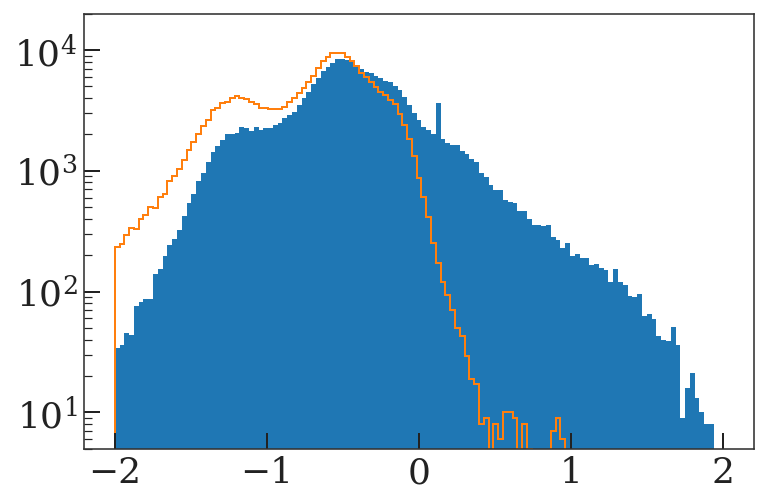

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bins = np.linspace(-2, 2, 128)
ax.hist(apogee_percentiles[:, 1], bins=bins, color='tab:blue')
ax.hist(control_percentiles[:, 1], bins=bins, color='tab:orange', 
        histtype='step', linestyle='-', linewidth=1);

ax.set_yscale('log')
ax.set_ylim(5, 2e4)

In [69]:
percentiles

array([ 1,  5, 50, 95, 99])

In [163]:
lnK_cut = 0.
n_control = (control_percentiles[:, 1] > lnK_cut).sum()

percentile_mask = apogee_percentiles[:, 1] > lnK_cut
n_apogee = percentile_mask.sum()

print(n_control, n_apogee)
print(n_control / n_apogee)

2448 35597
0.06876984015506925


Compare to simple likelihood ratio selection:

In [164]:
llr = metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood']
# llr = metadata['max_unmarginalized_ln_likelihood'] - metadata['constant_ln_likelihood']
llr_cut = 4.6
llr_mask = (llr > llr_cut)
llr_mask.sum()

31552

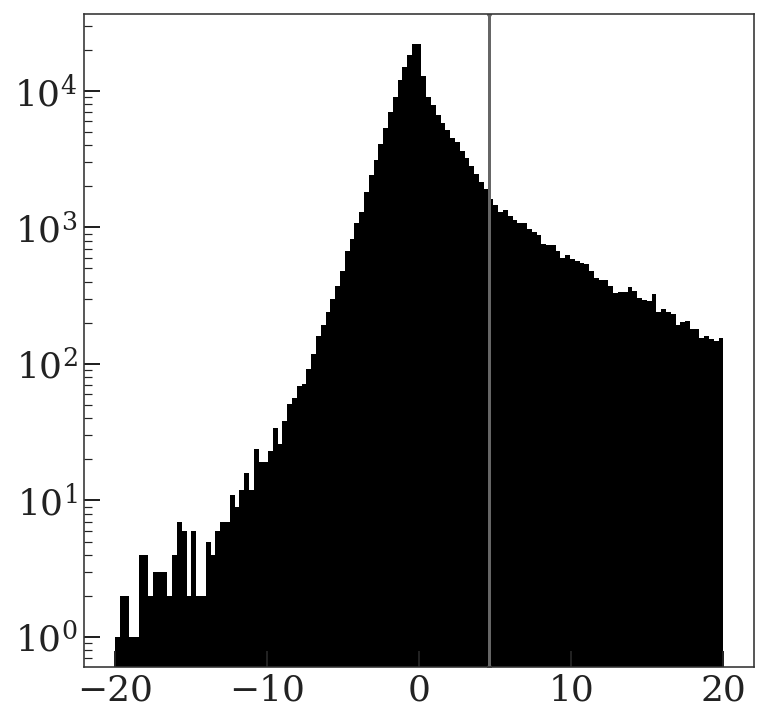

In [165]:
plt.hist(llr, bins=np.linspace(-20, 20, 128));
plt.yscale('log')
plt.axvline(llr_cut)

In [166]:
percentile_mask.sum()

35597

In [167]:
both_mask = (llr_mask & np.isin(metadata['APOGEE_ID'],
                                percentile_apogee_ids[percentile_mask]))
both_mask.sum()

19635

In [171]:
# neg_apids = metadata['APOGEE_ID'][~both_mask]
# pos_apids = metadata['APOGEE_ID'][both_mask & (llr < 5)]

# for apid1, apid2 in zip(neg_apids[10:30], 
#                         pos_apids[10:30]):
#     fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
#     for apid, ax in zip([apid1, apid2], axes):
#         visits = allvisit[allvisit['APOGEE_ID'] == apid]
#         data = get_rvdata(visits)
#         _ = data.plot(ax=ax)
#     fig.tight_layout()

In [173]:
name = f'lnK{lnK_cut:.1f}_logL{llr_cut:.1f}'
name

'lnK0.0_logL4.6'

In [174]:
metadata[both_mask].write(f'../catalogs/{name}_metadata.fits', overwrite=True)

In [176]:
final_samples_file = f'../catalogs/{name}_samples.hdf5'

In [177]:
with tb.open_file(final_samples_file, 'w') as cat_f:
    with tb.open_file(c.mcmc_results_path, 'r') as mcmc_f, tb.open_file(c.joker_results_path, 'r') as joker_f:
        table = None
        for i, row in enumerate(tqdm(metadata[both_mask])):
            apid = row['APOGEE_ID']

            if row['mcmc_success']:
                f = mcmc_f
            else:
                f = joker_f
            
            if table is None:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.create_table('/', 'samples', obj=table.as_array())
                
            else:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.root['samples'].append(table.as_array())

---

### Recompute the Kepler ln-evidence because the ln-prior values are not correct for all parameters:

Old stuff below: don't use the log-evidence-ratio!

In [ ]:
from hq.samples_analysis import ln_normal
from scipy.stats import beta
from scipy.special import logsumexp

In [15]:
with open(c.prior_file, 'r') as f:
    print(''.join(f.readlines()[8:18]))

with pm.Model() as model:
    s = xu.with_unit(pm.Lognormal('s', -2.5, 0.75),
                     u.km/u.s)

    prior = tj.JokerPrior.default(
        P_min=2*u.day, P_max=16384*u.day,
        sigma_K0=30*u.km/u.s,
        sigma_v=100*u.km/u.s,
        s=s
    )



In [17]:
prior = c.get_prior()

In [279]:
sigma_K0 = 30  # km/s
P0 = 365.25  # days

new_evis = []
with h5py.File(c.joker_results_path, 'r') as joker_f: 
    with h5py.File(c.mcmc_results_path, 'r') as mcmc_f: 
        for row in tqdm(metadata):
            apid = row['APOGEE_ID']
            
            if row['mcmc_success']:
                samples = mcmc_f[f'{apid}/samples']
            else:
                samples = joker_f[f'{apid}/samples']
            
            P = samples['P']
            e = samples['e']
            s = samples['s']
        
            lp = (-np.log(P) - np.log(np.log(8192))  # P
                  + beta.logpdf(e, 0.867, 3.03)  # e
                  + -np.log(2*np.pi)  # omega
                  + -np.log(2*np.pi)  # M0
                  + ln_normal(np.log(s), -2.5, 0.75**2) - np.log(s))   # s
            
            if row['mcmc_success']:
                var_K = sigma_K0**2 * (P/P0)**(-2/3) / (1-e**2)
                lp = (lp 
                      + ln_normal(samples['K'], 0, var_K)  # K
                      + ln_normal(samples['v0'], 0, 100**2))  # v0
                
            new_evi = (logsumexp(samples['ln_likelihood'] + lp)
                       - np.log(len(samples)))
            new_evis.append(new_evi)

In [281]:
len(metadata), len(new_evis)

(232495, 232495)

In [295]:
metadata['kepler_ln_evidence'] = new_evis
metadata.write(c.metadata_path, overwrite=True)

In [283]:
dev = metadata['kepler_ln_evidence'] - metadata['constant_ln_evidence']

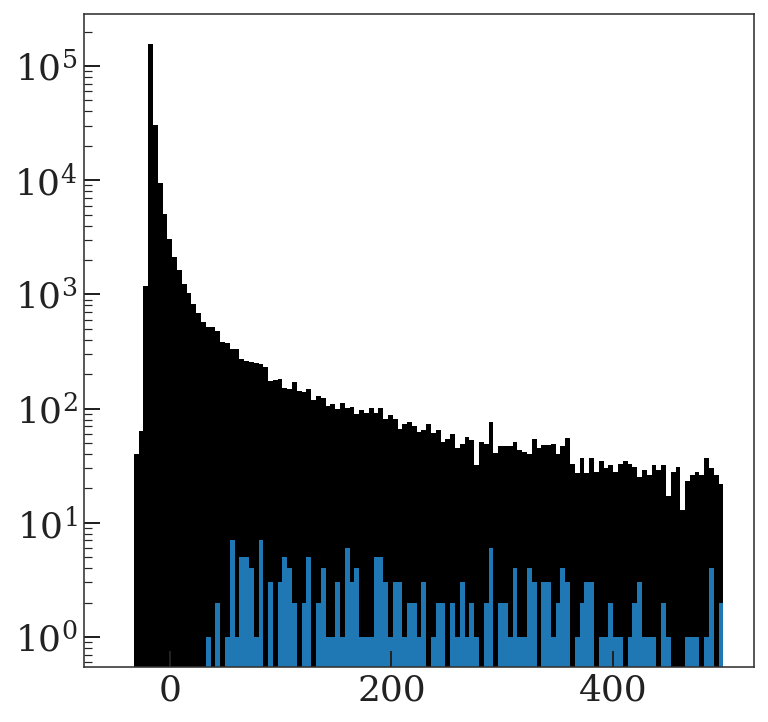

In [289]:
_, bins,_ = plt.hist(dev, bins=np.linspace(-50, 500, 128));
plt.hist(dev[metadata['mcmc_success']], bins=bins);
plt.yscale('log')

# Evidence ratio catalog

First produce the sub-selected metadata file:

In [312]:
ev_ratio = np.array(metadata['kepler_ln_evidence'] - metadata['constant_ln_evidence'])

for i in [0, 3, 10, 100]:
    print((ev_ratio > i).sum())

28738
26920
23984
14515


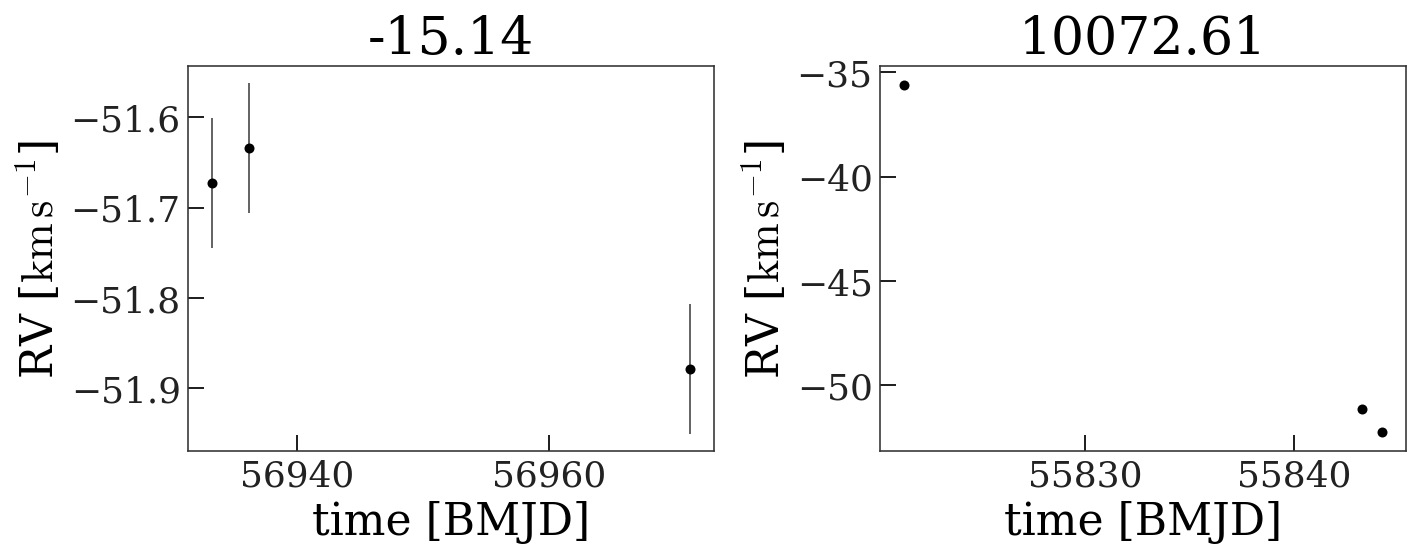

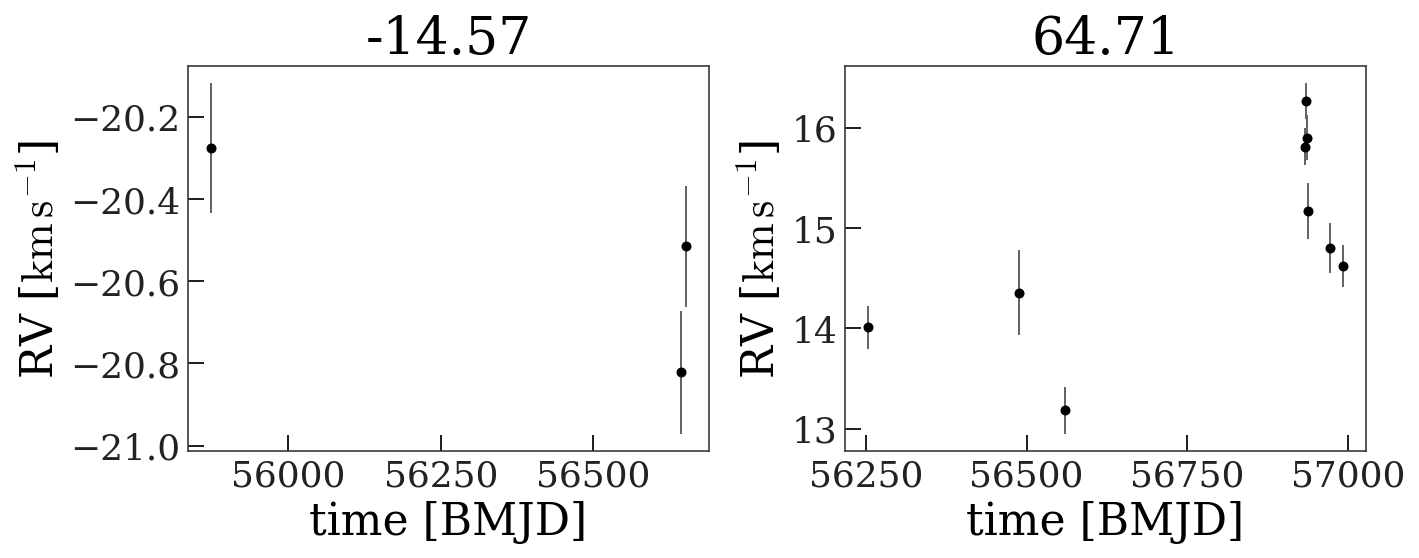

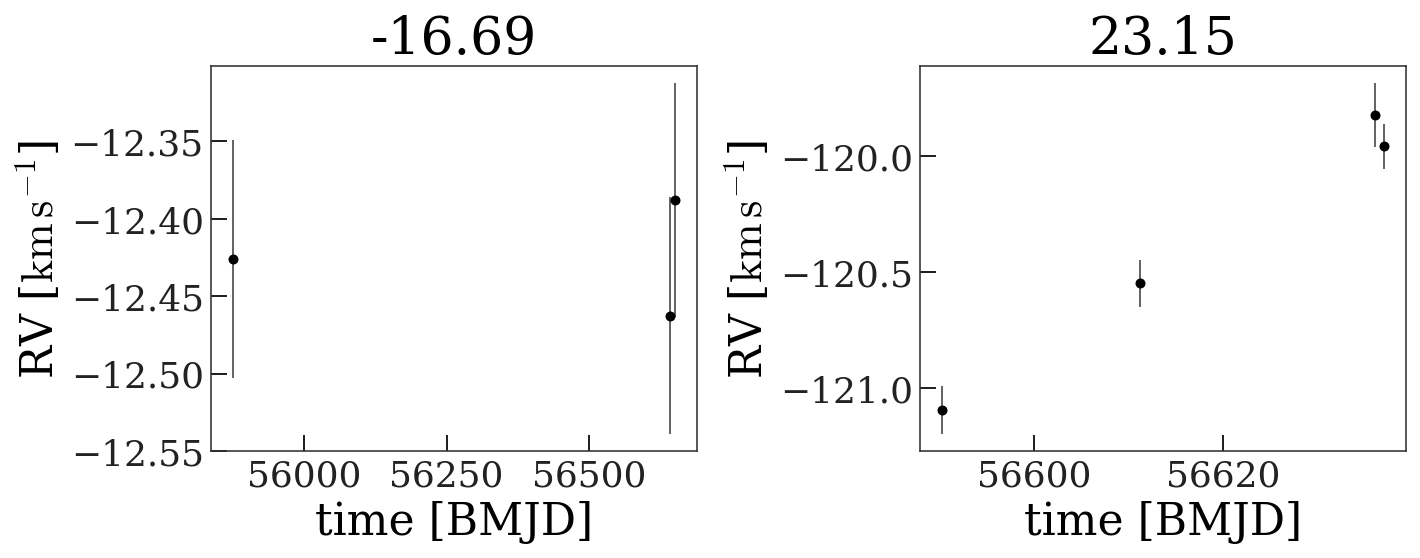

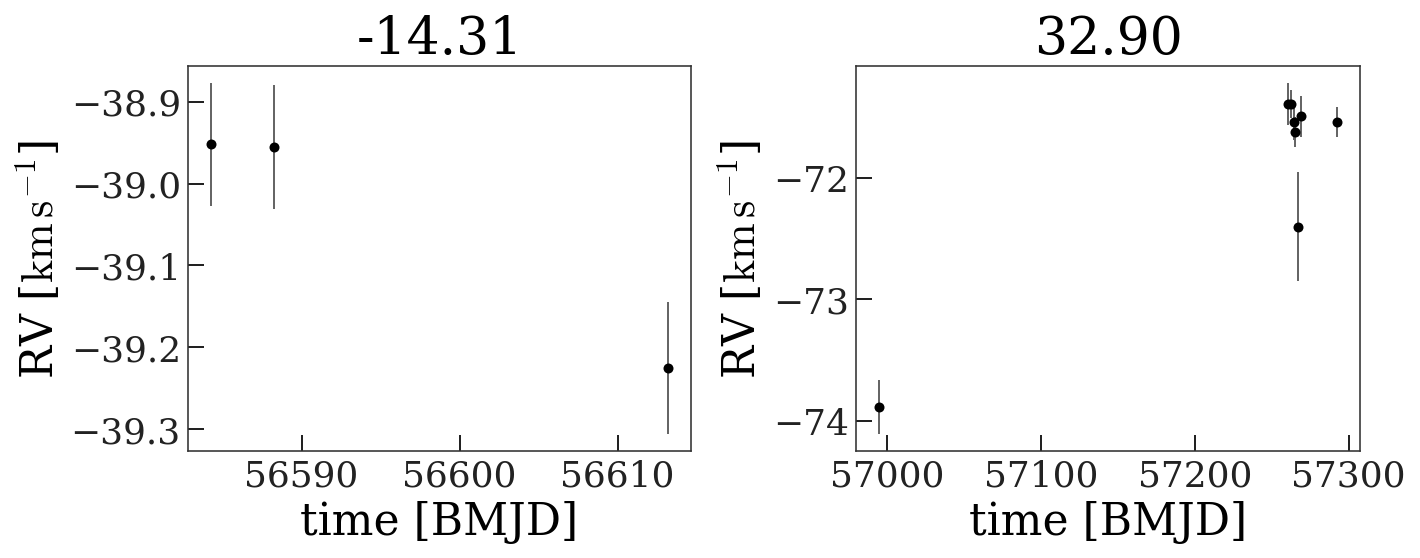

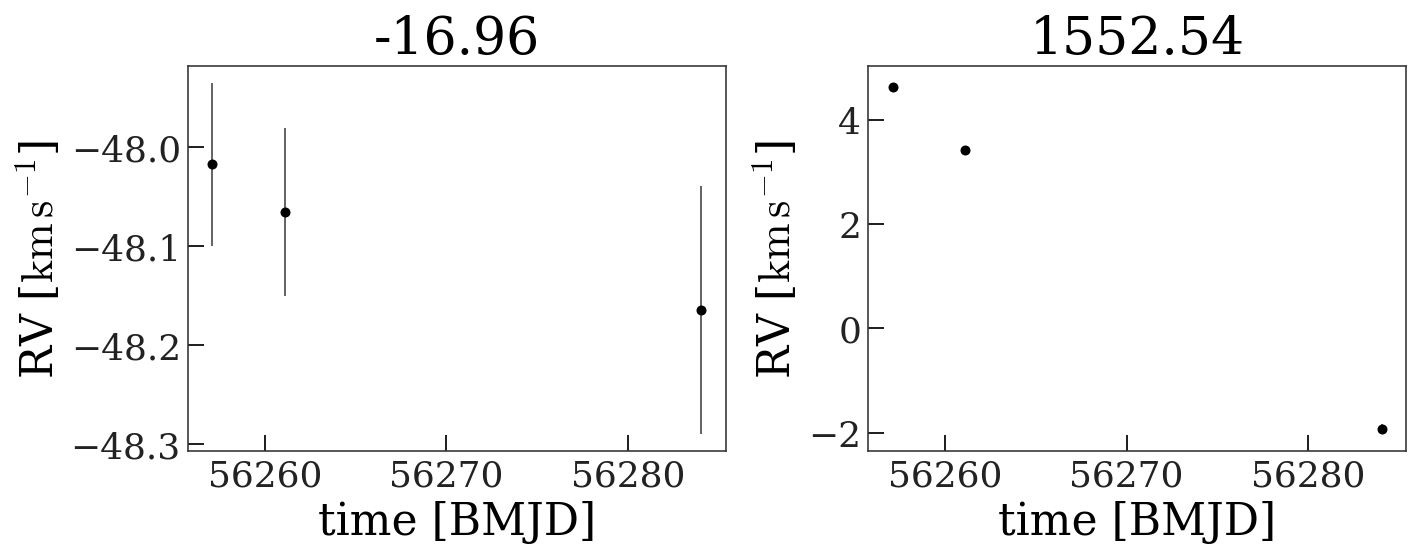

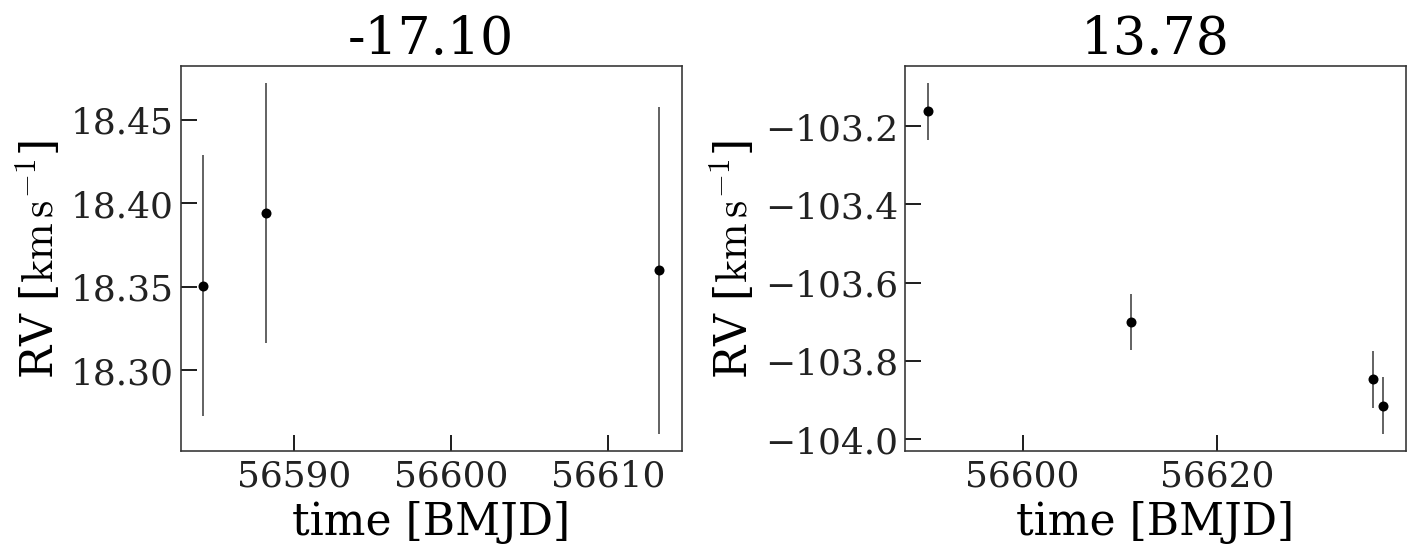

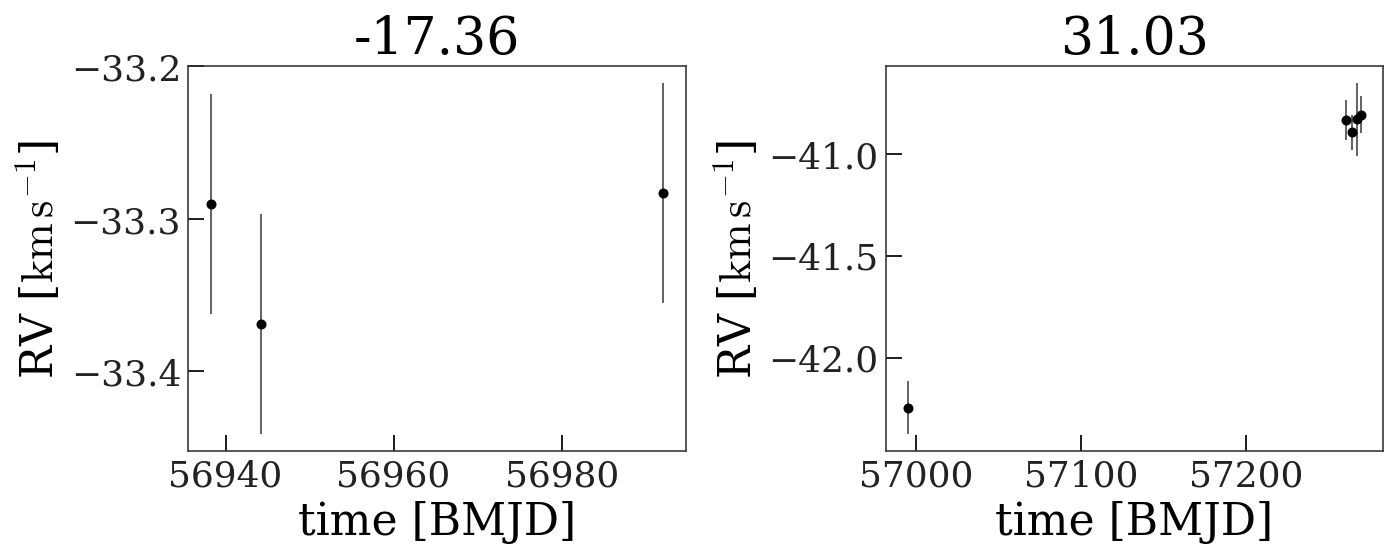

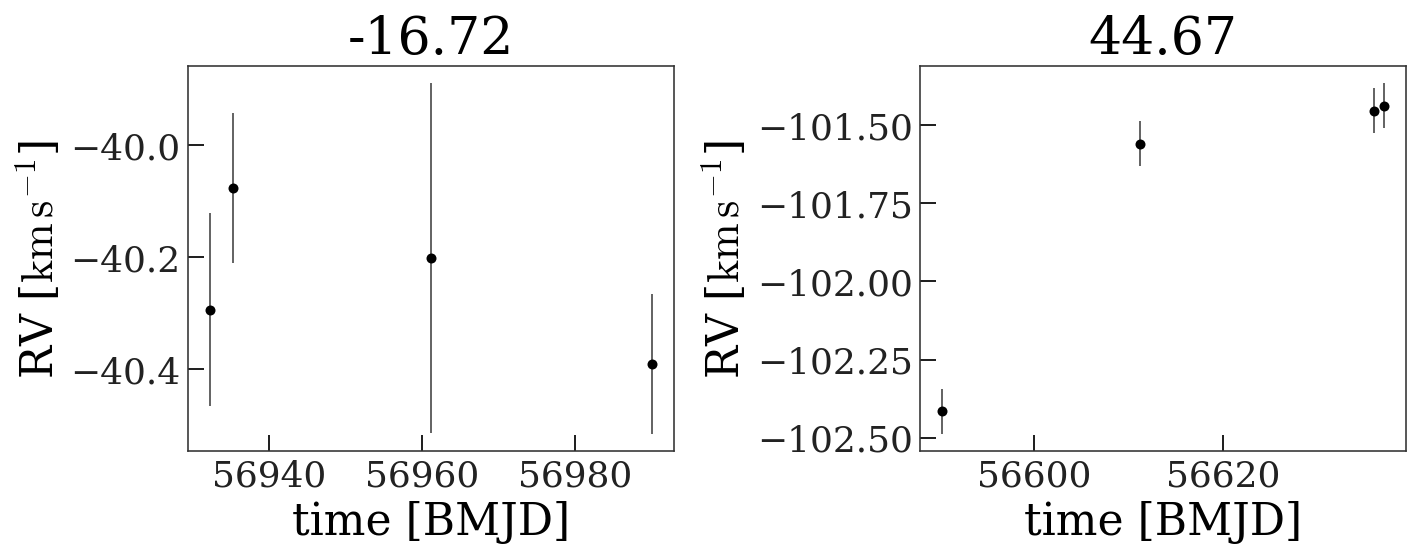

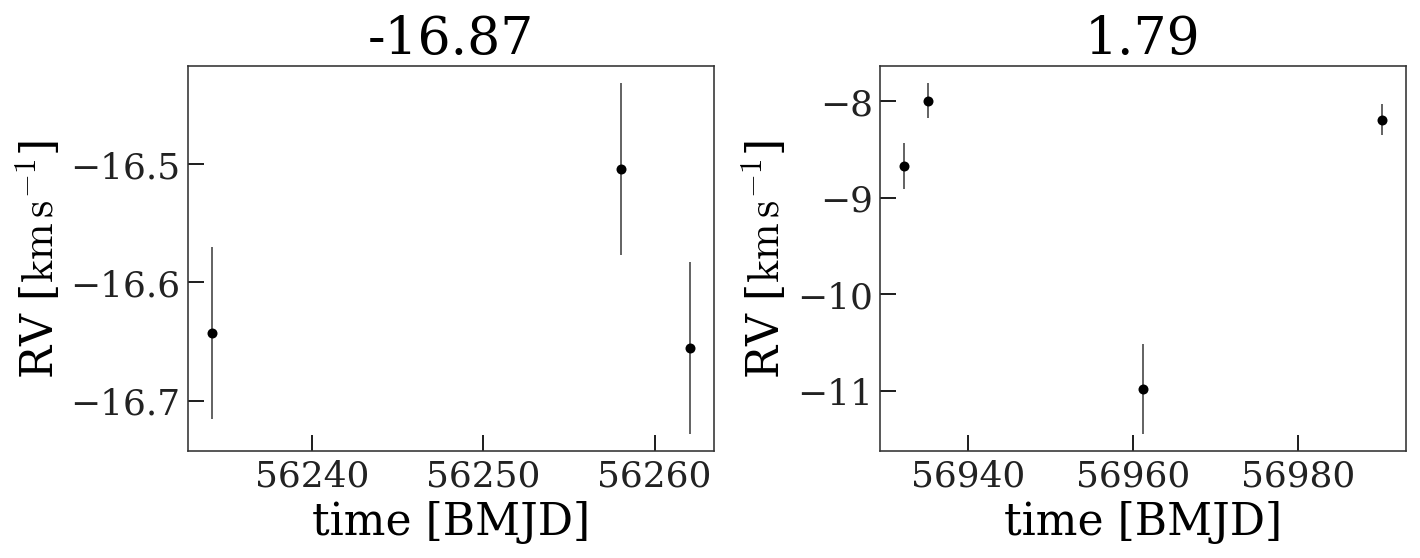

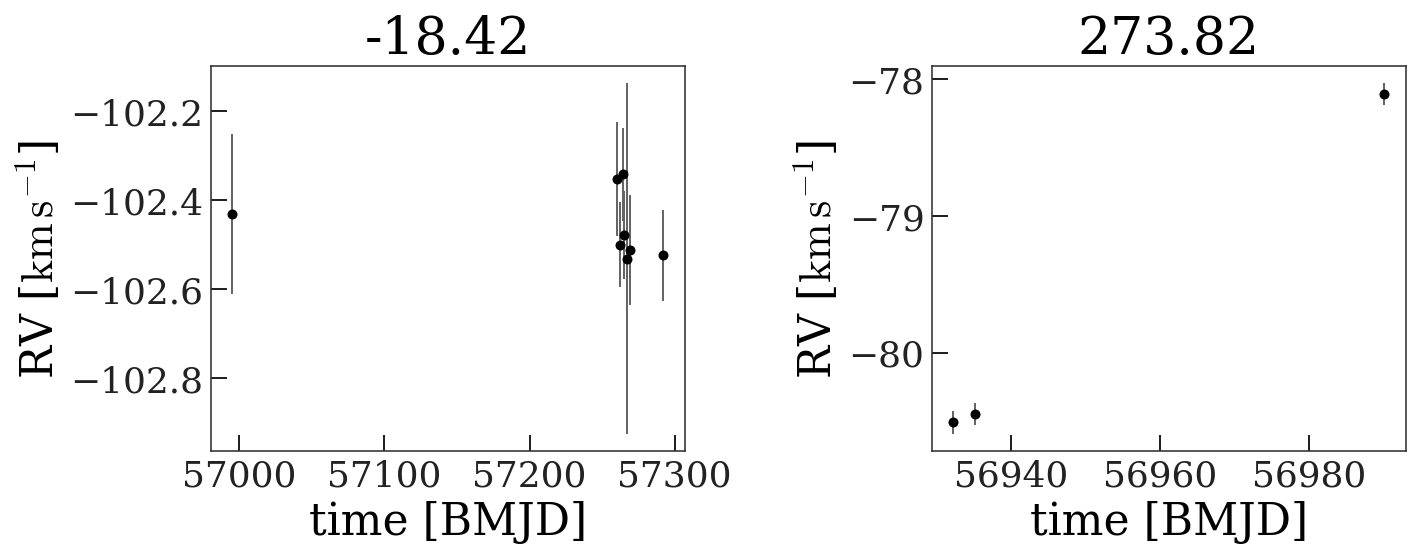

In [303]:
neg_apids = metadata['APOGEE_ID'][ev_ratio <= 0]
pos_apids = metadata['APOGEE_ID'][ev_ratio > 0]

for apid1, apid2 in zip(neg_apids[:10], 
                        pos_apids[:10]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for apid, ax in zip([apid1, apid2], axes):
        visits = allvisit[allvisit['APOGEE_ID'] == apid]
        data = get_rvdata(visits)
        _ = data.plot(ax=ax)
        ax.set_title('{:.2f}'.format(float(dev[metadata['APOGEE_ID'] == apid])))
    fig.tight_layout()

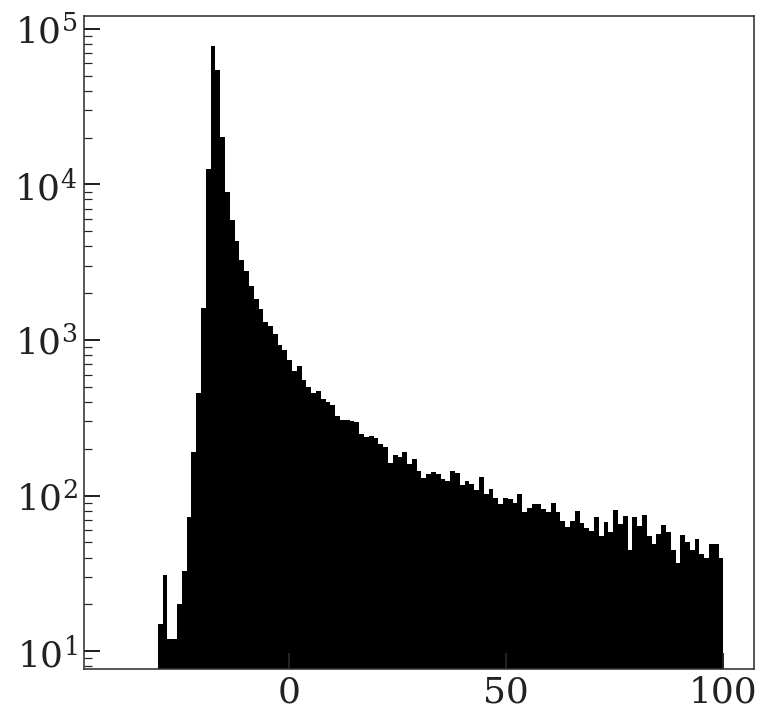

In [306]:
plt.hist(ev_ratio, bins=np.linspace(-40, 100, 128));
plt.yscale('log')

In [307]:
mask = (ev_ratio > 0) # & (ll_ratio > 3)
mask.sum()

28738

In [12]:
# apogee_ids = metadata[mask]['APOGEE_ID']
# for apid in apogee_ids[10:20]:
#     visits = allvisit[allvisit['APOGEE_ID'] == apid]
#     data = get_rvdata(visits)
    
#     plt.figure()
#     _ = data.plot()
#     plt.title('r={:.2f} r2={:.2f}'.format(ratio[metadata['APOGEE_ID'] == apid][0],
#                                           ratio2[metadata['APOGEE_ID'] == apid][0]))

In [308]:
metadata[mask].write('../catalogs/evidence_ratio_metadata.fits', overwrite=True)

Now collect all samplings:

In [309]:
evidance_catalog_samples_file = '../catalogs/evidence_ratio_samples.hdf5'

In [310]:
with tb.open_file(evidance_catalog_samples_file, 'w') as cat_f:
    if 'samples' in cat_f.root:
        done_apogee_ids = cat_f.root['samples'].read(field='APOGEE_ID').astype(str)
    else:
        done_apogee_ids = []
    
    with tb.open_file(c.mcmc_results_path, 'r') as mcmc_f, tb.open_file(c.joker_results_path, 'r') as joker_f:
        table = None
        for i, row in enumerate(tqdm(metadata[mask])):
            apid = row['APOGEE_ID']

            if row['mcmc_success']:
                f = mcmc_f
            else:
                f = joker_f
            
            if apid in done_apogee_ids:
                idx = np.where(done_apogee_ids == apid)[0]
                if (idx.max()-idx.min()) > 511:
                    print("NO!")
                cat_f.root['samples'].remove_rows(idx.min(), idx.max()+1)
            
            if table is None and len(done_apogee_ids) == 0:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.create_table('/', 'samples', obj=table.as_array())
                
            else:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.root['samples'].append(table.as_array())